# Navigation

---

## 0. Learning Algorithm

---

To solve the navigating agent problem, I choose [Deep Q-learning algorithm](http://dx.doi.org/10.1038/nature14236)(Mnih et al., Human-level control through deep reinforcement learning).

**Algorithm**

In this problem, An agent will navigate the square world and collect bananas. Since it receives 37 dimensional state space where each entry has continuos values, Finding action value function with Q-table is not enough. Instead deep nueral networks can be used as a nonlinear function approximator.Full deep Q-leaning algorithm is presented as follows. For this problem, Agent gets low dimensional state space instead of raw pixel inputs, So it doesn't need preprocessing($\Phi$) the input.



<br>
<figure>
  <img src = "./pic/dqn_algorithm.png" width = 70% style = "border: thin silver solid; padding: 10px">
      <figcaption style = "text-align: center; font-style: italic">Fig 1. - Deep Q-learning Algorithm.</figcaption>
</figure> 
<br>




Deep Q-learning alogithm uses not only neural networks but also replay buffer and fixed Q-target techique. Replay buffer stores old experiences and samples a small batch of tuples to remove correlations in consecutive observations. This enables learning algorithm to be optimized by mini-bactch gradient decent algorithm. The Authors use RMSProp as optimizer. Since Adam optimizer is considered outperform RMSProp([Kingma et al.](https://arxiv.org/abs/1412.6980)), Therefore I used Adam optimizer.

With the fixed Q-target techique, They used seperate target network which is updated periodically, to reduce correlation with TD targets. The target network has fixed parameters, so it produces the fixed Q-target untill it is updated. Therefore this leads to much more stable learning. But the initial result was not that promising, It is still hard to converge. So I used soft update method suggested by Lillicrap et al.([Continuous control with deep reinforcement learning](http://arxiv.org/abs/1509.02971)) and compared the performance of these two methods. 

**Hyperparamters**

All these hyperparamters are inspired by the paper's list of hyperparameters and their values.
Buffer size and batch size are much smaller since the task is more simple. 

```
LR = 1e-3              # learning rate for adam optimizer
BATCH_SIZE = 128       # minibatch size for replay memory
BUFFER_SIZE = int(1e4) # buffer size of replay memory
GAMMA = 0.99           # discount factor
TAU = 1e-3             # soft update
UP_FREQ = 4            # update frequency for target network
EPS_START = 1.0        # intial epsilon value
EPS_END = 0.01         # final epsilon value
EPS_DECAY = 0.995      # epsilon deacy rate
```

**Model Architecture**

Since this reacher problem is low dimensional problem, The Q-network is consist of few several fully connected layers. It gets states as input and ouputs the action-value. 

```
Network(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)
```


## 1.Implementation
---
The network model and agent code are implemented in model.py and agent.py.

1. model.py
    - Network Class
2. agent.py
    - Replay Buffer Class
    - Agent Class

In [1]:
# Load the model.py and agent.py
%load_ext autoreload
%autoreload 1
%aimport model, agent

In [2]:
from collections import deque
import matplotlib.pyplot as plt
import torch
%matplotlib inline

from agent import Agent

## 2. Traning
---
### 1.Training Code

In [3]:
from unityagents import UnityEnvironment
import numpy as np

# specifcy where the environment binary file is located.
env = UnityEnvironment(file_name="data/Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
# env_info.vector_observations.shape : (1,37)
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


In [6]:
# Objecitve average score
GOAL_AVG_SCORE = 13

In [7]:
# Agent with vanilla update
agent_1 = Agent(state_size=state_size, action_size=action_size, seed=2, soft_update=False)
agent_1_name = 'no_soft_update'

In [9]:
# Agent with soft update
agent_2 = Agent(state_size=state_size, action_size=action_size, seed=2, soft_update=True)
agent_2_name = 'soft_update'

In [10]:
def dqn(agent, checkpoint_name, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    
    solved = False
    scores=[] # for plotting score graph
    scores_window = deque(maxlen=100) # for calculating mean of consecutive scores
    eps = eps_start # intial epsilon
    
    for i_episode in range(1, n_episodes+1):
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        for t in range(max_t):
            action = agent.act(state, eps)
            # type of action can be either np.int32 or np.int64  
            # Typecast into int
            env_info = env.step(int(action))[brain_name]
            reward = env_info.rewards[0]
            next_state = env_info.vector_observations[0]
            done = env_info.local_done[0]
            
            agent.step(state, action, reward, next_state,done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score) 
        scores.append(score)
        # decay the epsilon
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\t Score: {:.2f}'.format(i_episode, score), end="")
        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=GOAL_AVG_SCORE and solved==False:
            solved_episode = i_episode
            solved=True
            print('\r The number of episodes needed to solve the problem : {}'
                  .format(solved_episode))
    if solved==True:
        torch.save(agent.qnetwork_local.state_dict(), './model/'+checkpoint_name+'_checkpoint.pth')
    return scores

In [11]:
N_episode = 1000
MAX_timestep = 1000
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995

In [12]:
scores_1 = dqn(agent_1,agent_1_name,N_episode, MAX_timestep, EPS_START,EPS_END, EPS_DECAY)            

Episode 50	Average Score: -0.08
Episode 100	Average Score: -0.09
Episode 150	Average Score: -0.04
Episode 200	Average Score: -0.14
Episode 250	Average Score: -0.38
Episode 300	Average Score: -0.17
Episode 350	Average Score: 0.17
Episode 400	Average Score: 0.40
Episode 450	Average Score: 1.28
Episode 500	Average Score: 1.74
Episode 550	Average Score: 1.53
Episode 600	Average Score: 1.83
Episode 650	Average Score: 2.96
Episode 700	Average Score: 4.85
Episode 750	Average Score: 4.71
Episode 800	Average Score: 5.27
Episode 850	Average Score: 4.11
Episode 900	Average Score: 2.50
Episode 950	Average Score: 1.92
Episode 1000	Average Score: 1.63


In [13]:
scores_2 = dqn(agent_2,agent_2_name,N_episode, MAX_timestep, EPS_START,EPS_END, EPS_DECAY)            

Episode 50	Average Score: 0.14
Episode 100	Average Score: 0.11
Episode 150	Average Score: 0.40
Episode 200	Average Score: 0.98
Episode 250	Average Score: 2.73
Episode 300	Average Score: 4.95
Episode 350	Average Score: 6.61
Episode 400	Average Score: 8.24
Episode 450	Average Score: 8.60
Episode 500	Average Score: 8.33
Episode 550	Average Score: 10.32
Episode 600	Average Score: 12.57
Episode 650	Average Score: 12.68
Episode 700	Average Score: 12.24
Episode 750	Average Score: 12.19
Episode 800	Average Score: 12.72
 The number of episodes needed to solve the problem : 817
Episode 850	Average Score: 13.15
Episode 900	Average Score: 13.40
Episode 950	Average Score: 13.95
Episode 1000	Average Score: 13.90


### 2. Plot of Rewards

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

**DQN without soft update**

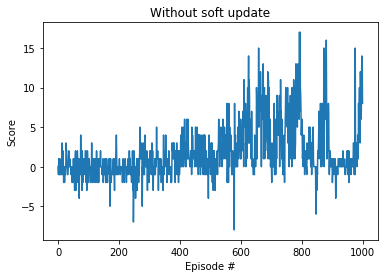

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_1)), scores_1)
plt.title('Without Soft Update')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

**DQN with soft update**

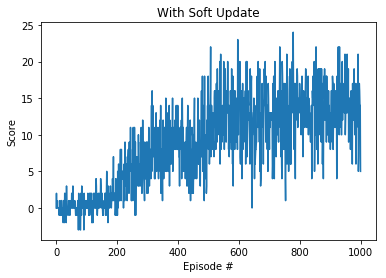

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_2)), scores_2)
plt.title('With Soft Update')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 3.  Watch a Smart Agent



In [17]:
# load the weights from file
agent_2.qnetwork_local.load_state_dict(torch.load('./model/'+agent_2_name+'_checkpoint.pth'))

In [18]:
score = 0
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
while True:
    action = agent_2.act(state)

    env_info = env.step(int(action))[brain_name]
    reward = env_info.rewards[0]
    next_state = env_info.vector_observations[0]
    done = env_info.local_done[0]

    state = next_state
    score += reward
    if done:
        break 
            
env.close()

## 4. Ideas for Future Work

Even though the problem can be solved by the current settings, It has several things to be imporved. First off, Fine-tuning hyper-paramters might be good start, but it can cost many times. There are many extensions of original deep Q-alogrithm, So I  will consider adopting those models.

1. [Prioritized Experience Replay](https://arxiv.org/abs/1511.05952) 

    Current replay buffer samples the experience unfiormly. But certain experience might be more important than ohters. So by giving some probability based on priority to each experince, Replay buffer can sample important expericens more frequently.
    
        
2. [Double DQN](https://arxiv.org/abs/1509.06461)
    
    Q-learning is prone to do overestimation of Q-values. Hasselt et al. suggested the double DQN to deal with this problem. 2 seperate netowrk is used to decouple the max operation in the target. Unless both network agree that the action has max Q-value, the the target is not overestimated. 
    
    
3. [Deulling DQN](https://arxiv.org/abs/1511.06581)

    The Q-network estimates action value for each states. Deulling DQN has two seperate estimators. One for estimating state value function, and the other for estimating state-dependent action advantage function. Therefore It has seperate representation of state and action. The authors show that the dueling DQN can more quickly idenfiy the correct action during policy evaluation.

<br>
<figure>
  <img src = "./pic/duel_dqn.png" width = 50% style = "border: thin silver solid; padding: 10px">
      <figcaption style = "text-align: center; font-style: italic">Deulling DQN Architecture.</figcaption>
</figure> 
<br>